In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.asap_data_io import parse_config, load_observed_data, \
    config_observed_data, config_um_data, load_um_data
from asap.asap_utils import mcmc_save_pickle, mcmc_save_results, \
    mcmc_initial_guess, mcmc_samples_stats, mcmc_save_results
from asap.asap_model_setup import setup_model
from asap.asap_likelihood import asap_flat_prior, asap_ln_like

from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare the configuration file

In [2]:
config_file = '../asap/asap_default_config.yaml'

cfg_ini = parse_config(config_file)

In [15]:
print(cfg_ini)

{'um_min_scatter': 0.01, 'param_ini': [0.599, 3.669, -0.048, 0.02, 0.8, 0.11], 'obs_smf_cov': 's16a_wide2_massive_smf_m100_m10_cov.npy', 'obs_wl_sample': 's16a_wide2_massive_boxbin3_default', 'obs_omega_m': 0.307, 'obs_smf_tot': 's16a_wide2_massive_smf_m100_new.npy', 'obs_smf_full_fits': 'primus_smf_z0.3_0.4.fits', 'um_mtot_nbin_min': 7, 'param_sig': [0.05, 0.1, 0.02, 0.005, 0.05, 0.05], 'mcmc_wl_only': False, 'mcmc_nsamples': 200, 'um_model': 'um_smdpl_0.7124_new_vagc_mpeak_11.5.npy', 'obs_smf_inn': 's16a_wide2_massive_smf_m10_new.npy', 'obs_h0': 0.7, 'obs_minn_col': 'logm_10', 'um_wl_add_stellar': False, 'obs_dir': '../data/s16a_massive_wide2', 'obs_area': 145.0, 'um_redshift': 0.3637, 'mcmc_wl_weight': 1.0, 'um_wl_nbin': 22, 'obs_cat': 's16a_wide2_massive_fsps1_imgsub_use_short.fits', 'mcmc_prefix': 'asap_smdpl', 'mcmc_smf_only': False, 'mcmc_nthreads': 2, 'um_dir': '../data/s16a_massive_wide2/um2', 'um_min_mvir': 11.5, 'um_lbox': 400.0, 'um_mtot_nbin': 80, 'um_wl_cat': 'um_smdpl_0.

### Load the data

In [3]:
global cfg, obs_data, um_data

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin3_default
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_new.npy
# Covariances for SMFs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# There are 15 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.5000 -- 12.2000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


### Test minimizing the chi2

In [6]:
def asap_chi2_lmfit(param):
    """Calculate the lnLikelihood of the model."""
    # Generate the model predictions
    (um_smf_tot, um_smf_inn, um_dsigma_profs) = asap_predict_model(
        param, cfg, obs_data, um_data)

    smf_lnlike = asap_smf_lnlike(
        obs_data['obs_smf_tot'], um_smf_tot,
        obs_smf_inn=obs_data['obs_smf_inn'],
        um_smf_inn=um_smf_inn)

    dsigma_lnlike = np.nansum([
        asap_dsigma_lnlike(obs_dsigma_prof, um_dsigma_prof)
        for (obs_dsigma_prof, um_dsigma_prof) in
        zip(obs_data['obs_wl_dsigma'], um_dsigma_profs)])
    
    return -(smf_lnlike + dsigma_lnlike)

In [80]:
from asap.asap_likelihood import asap_chi2
from scipy.optimize import least_squares

chi2_args = [cfg, obs_data, um_data]

param_ini = [0.6, 3.52, -0.0328, 0.1, 0.9, 0.1]
param_bounds = (cfg['param_low'], cfg['param_upp'])

res_1 = least_squares(asap_chi2_lmfit, param_ini, bounds=param_bounds,
                      loss='cauchy', f_scale=0.1, gtol=1e-12, xtol=1e-12,
                      verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2652e-02                                    2.15e+04    
       1             15         8.2578e-02      7.47e-05       2.00e-08       3.06e+04    
       2             16         8.2055e-02      5.23e-04       6.46e-09       9.39e+04    
       3             24         8.2055e-02      0.00e+00       0.00e+00       9.39e+04    
`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 8.2652e-02, final cost 8.2055e-02, first-order optimality 9.39e+04.


In [81]:
from scipy.optimize import minimize

res_2 = minimize(asap_chi2_lmfit, param_ini, method='Nelder-Mead', tol=1e-6)

In [83]:
res_2

 final_simplex: (array([[ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612],
       [ 0.60004776,  3.51908816, -0.03279398,  0.10023226,  0.93908365,
         0.09987612]]), array([358.25044965, 385.20078156, 390.63204465, 393.01142531,
       395.29419835, 403.52581343, 406.52140468]))
           fun: 358.2504496462037
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1200
           nit: 454
        status: 1
       success: False
           

### Test Model prediction and plots

/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 70.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 107.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))


[ 2.27231170e-05  2.67797814e-05  1.37570824e-05  5.25690777e-06
  1.49986393e-07 -4.79359251e-07  1.52960730e-07 -4.39241456e-08
  4.99523027e-08 -1.03989780e-07 -5.38897711e-07  4.43795534e-06
  2.14403284e-05  3.04818545e-05  1.18672802e-05  5.71985127e-07
  4.68072809e-08  6.46010800e-08]
239.40017303550488
[ -631781.68138466  1272413.89797958  1262884.96535786  2533144.48813113
 -1703917.63651006 -6729309.69522521 12249323.43422799  2606877.34878498
  6978481.63723266 -1317244.64108776   183972.52408514  -311914.03837542
   723872.75583012   -78597.64043402  -419985.85744161  -109715.4808451
  1505804.08279388 -2319759.60128882]
[ 2.03856239e-05  2.40040083e-05  1.48771312e-05  5.30560554e-06
 -6.77875761e-07 -4.10792872e-08 -3.34017008e-07  4.77362810e-09
 -4.74432448e-08 -1.03989780e-07 -2.95408842e-07  4.24316424e-06
  1.98819996e-05  2.80469658e-05  1.11855113e-05  5.23287353e-07
 -1.89049290e-09  1.59033063e-08]
239.40017303550488
[  -320961.71354998    798815.89891716   1114

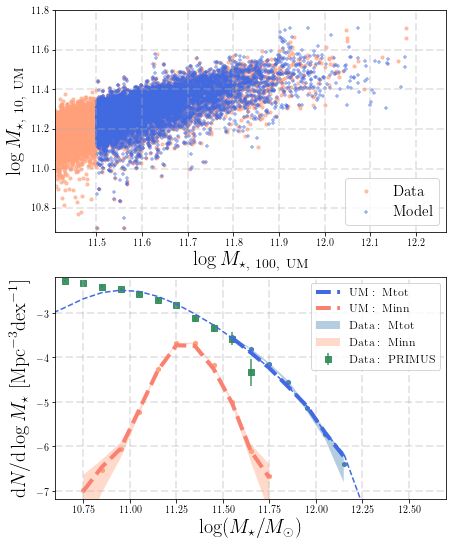

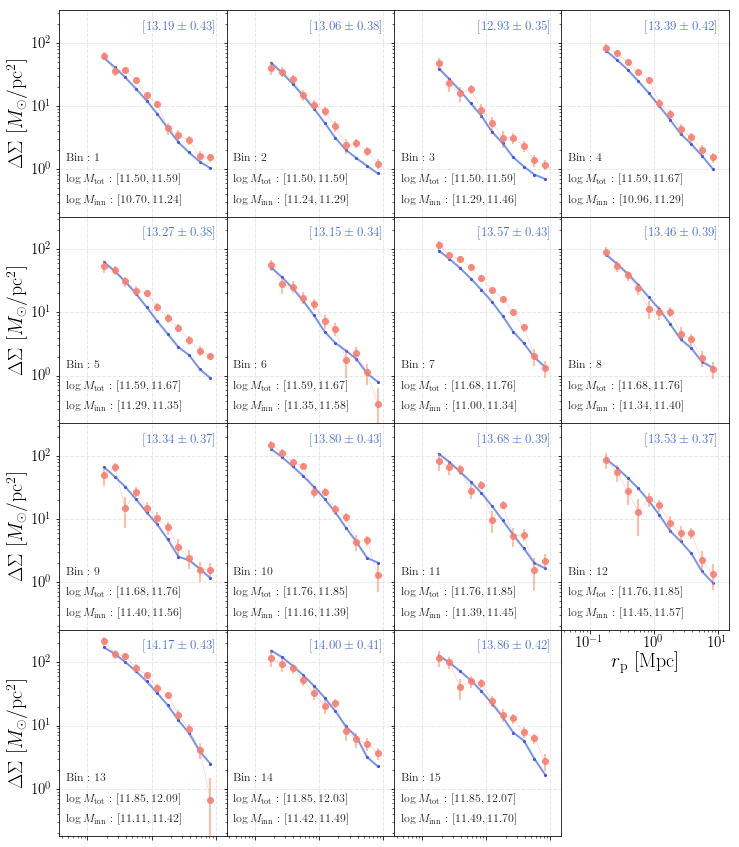

In [4]:
param_frac1 = [0.59585872, 3.70478962, -0.0203854, 0.077707, 
               0.71230225, 0.13759183]
param_frac1 = [0.58402975, 3.85827645, -0.03030363, 0.06531439,  
               0.64113185, 0.15288432]

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac1, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac1, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac1, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)

In [50]:
%timeit um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(param_frac1, cfg, obs_data, um_data)

1 loop, best of 3: 326 ms per loop


In [52]:
%timeit asap_ln_like(param_frac1, cfg, obs_data, um_data, chi2=False)

1 loop, best of 3: 312 ms per loop


### Test new frac1 model

In [18]:
config_file = '/Users/song/Downloads/asap_smdpl_mmax_m10_cov_dynesty_test1.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin5_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_new.npy
# Covariances for SMFs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 11 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume

In [135]:
asap_test1 = np.load('/Users/song/Downloads/asap_smdpl_mmax_m10_test1_run.npz')
asap_test1_best = asap_test1['best']
print(asap_test1_best)

[ 0.68321688  2.47050856 -0.04369866  0.06982716  0.61092154  0.11253999]


In [34]:
param_frac1 = [0.60876125, 3.54527353, -0.02909479, 0.0524542, 0.75483027, 0.10869406]
param_frac1 = [0.68321688, 2.47050856, -0.04369866, 0.06982716, 0.61092154, 0.11253999]

param_frac1 = [0.59076125, 3.89007353, -0.02509479, 0.0724542, 0.60483027, 0.15869406]

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac1, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac1, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

[-1.24877724e-04 -5.96907900e-05 -3.08472016e-05 -1.42986838e-05
 -7.27683775e-06 -1.94494748e-06 -6.93893260e-07  9.21691756e-08
  1.47347850e-07 -3.47478649e-07 -7.33688806e-07  2.44527403e-05
  7.79297459e-05 -2.99520827e-05 -5.40695055e-05 -1.31607871e-05
 -1.02454374e-06 -3.73678884e-07]
-464.17688802121586
[-4.90592132e+07  6.33248556e+07  7.74879980e+07  3.49336488e+07
  9.13236989e+07  1.07126636e+09  7.06443892e+07  1.07092785e+08
  4.38566773e+07  1.95749394e+07 -3.62131294e+07  3.06163907e+06
  4.25350821e+07 -6.71001464e+06 -8.61296648e+07 -2.29047528e+08
  1.57833762e+08 -1.94267315e+09]
[-1.19131386e-04 -6.58267095e-05 -3.02141306e-05 -1.34708216e-05
 -6.40027783e-06 -2.48062299e-06 -1.03477768e-06  9.21691756e-08
  1.47347850e-07 -1.52687554e-07 -5.87595485e-07  2.47936248e-05
  7.78323504e-05 -2.94651050e-05 -5.47512743e-05 -1.26251116e-05
 -8.29752647e-07 -3.73678884e-07]
-464.17688802121586
[-4.09028083e+07  5.42725840e+07  7.01544301e+07  3.50693132e+07
  7.94560283e

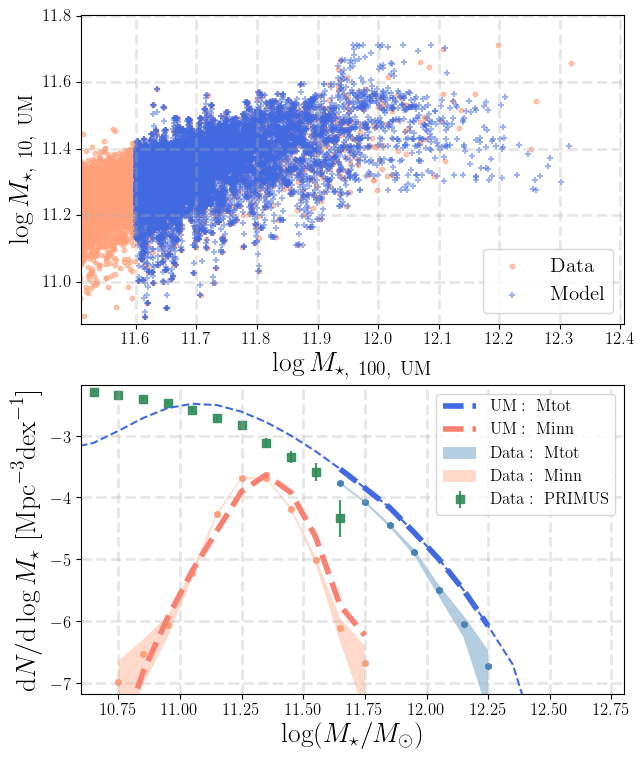

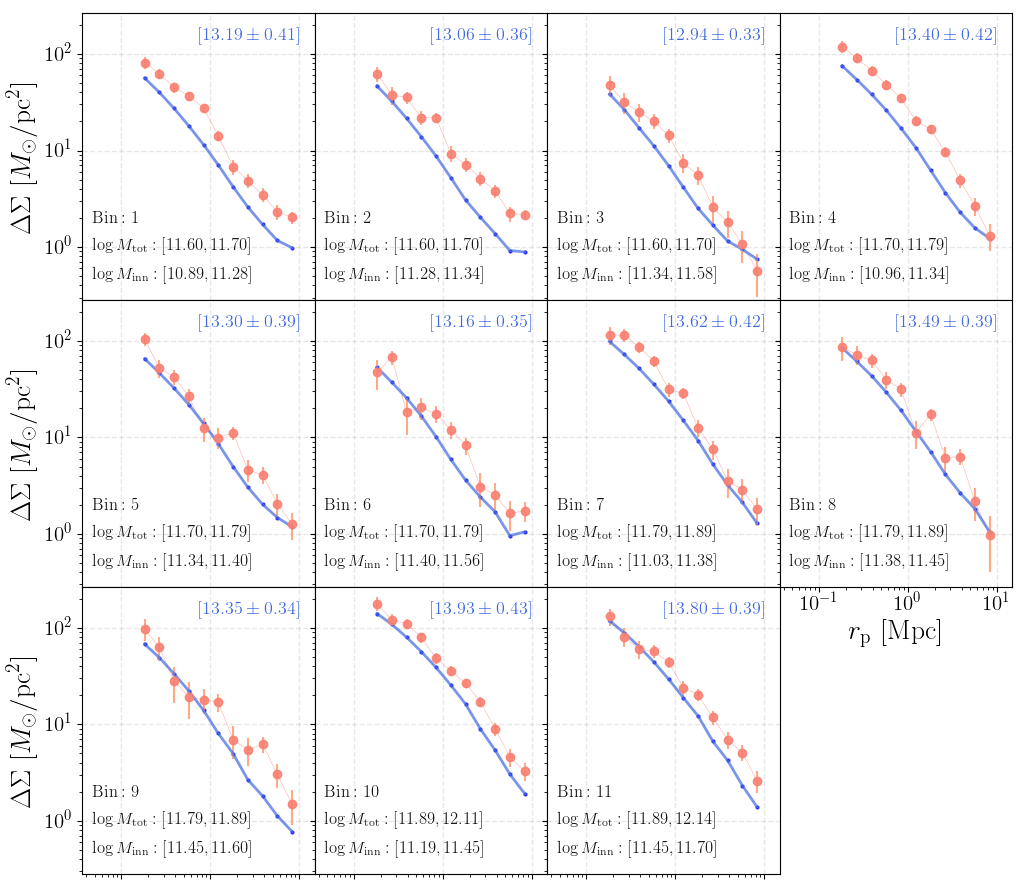

In [33]:
um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac1, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)

### Test new frac2 model 

In [310]:
config_file = '/Users/song/Downloads/asap_smdpl_mmax_m10_test2.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin5_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.5.fits
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 14 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.5000 -- 12.4000 in 9 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    9 bins at 11.50 < logMtot < 12.40
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [311]:
asap_test2 = np.load('/Users/song/Downloads/asap_smdpl_mmax_m10_test2_run.npz')
asap_test2_best = asap_test2['best']
print(asap_test2_best)

[ 0.58849437  3.63967461 -0.02116311  0.13441921  0.77425369  0.29504313]


In [312]:
param_frac2 = asap_test2_best

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac2, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac2, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

# lnLikelihood: 111.845339, -405.239369, -293.394030
# Chi2: 254.336798, 223.235516, 477.572314
# N_data - N_param: 167


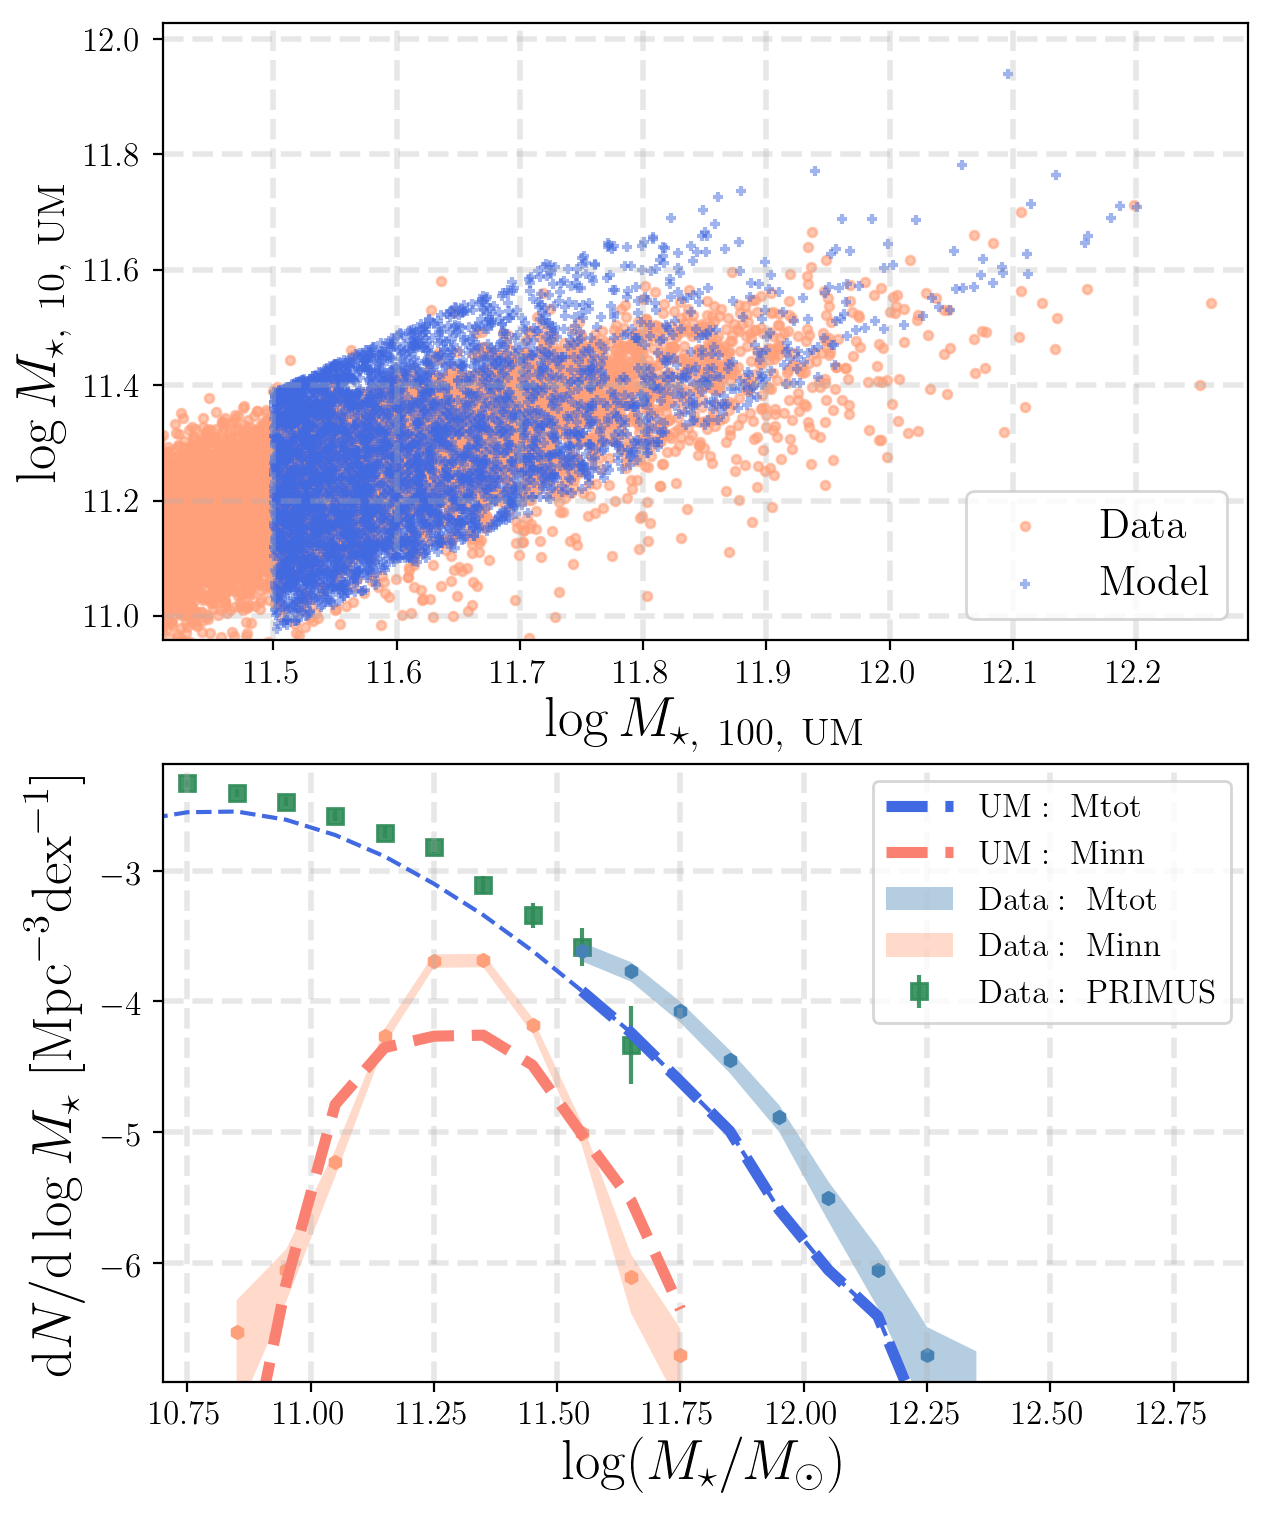

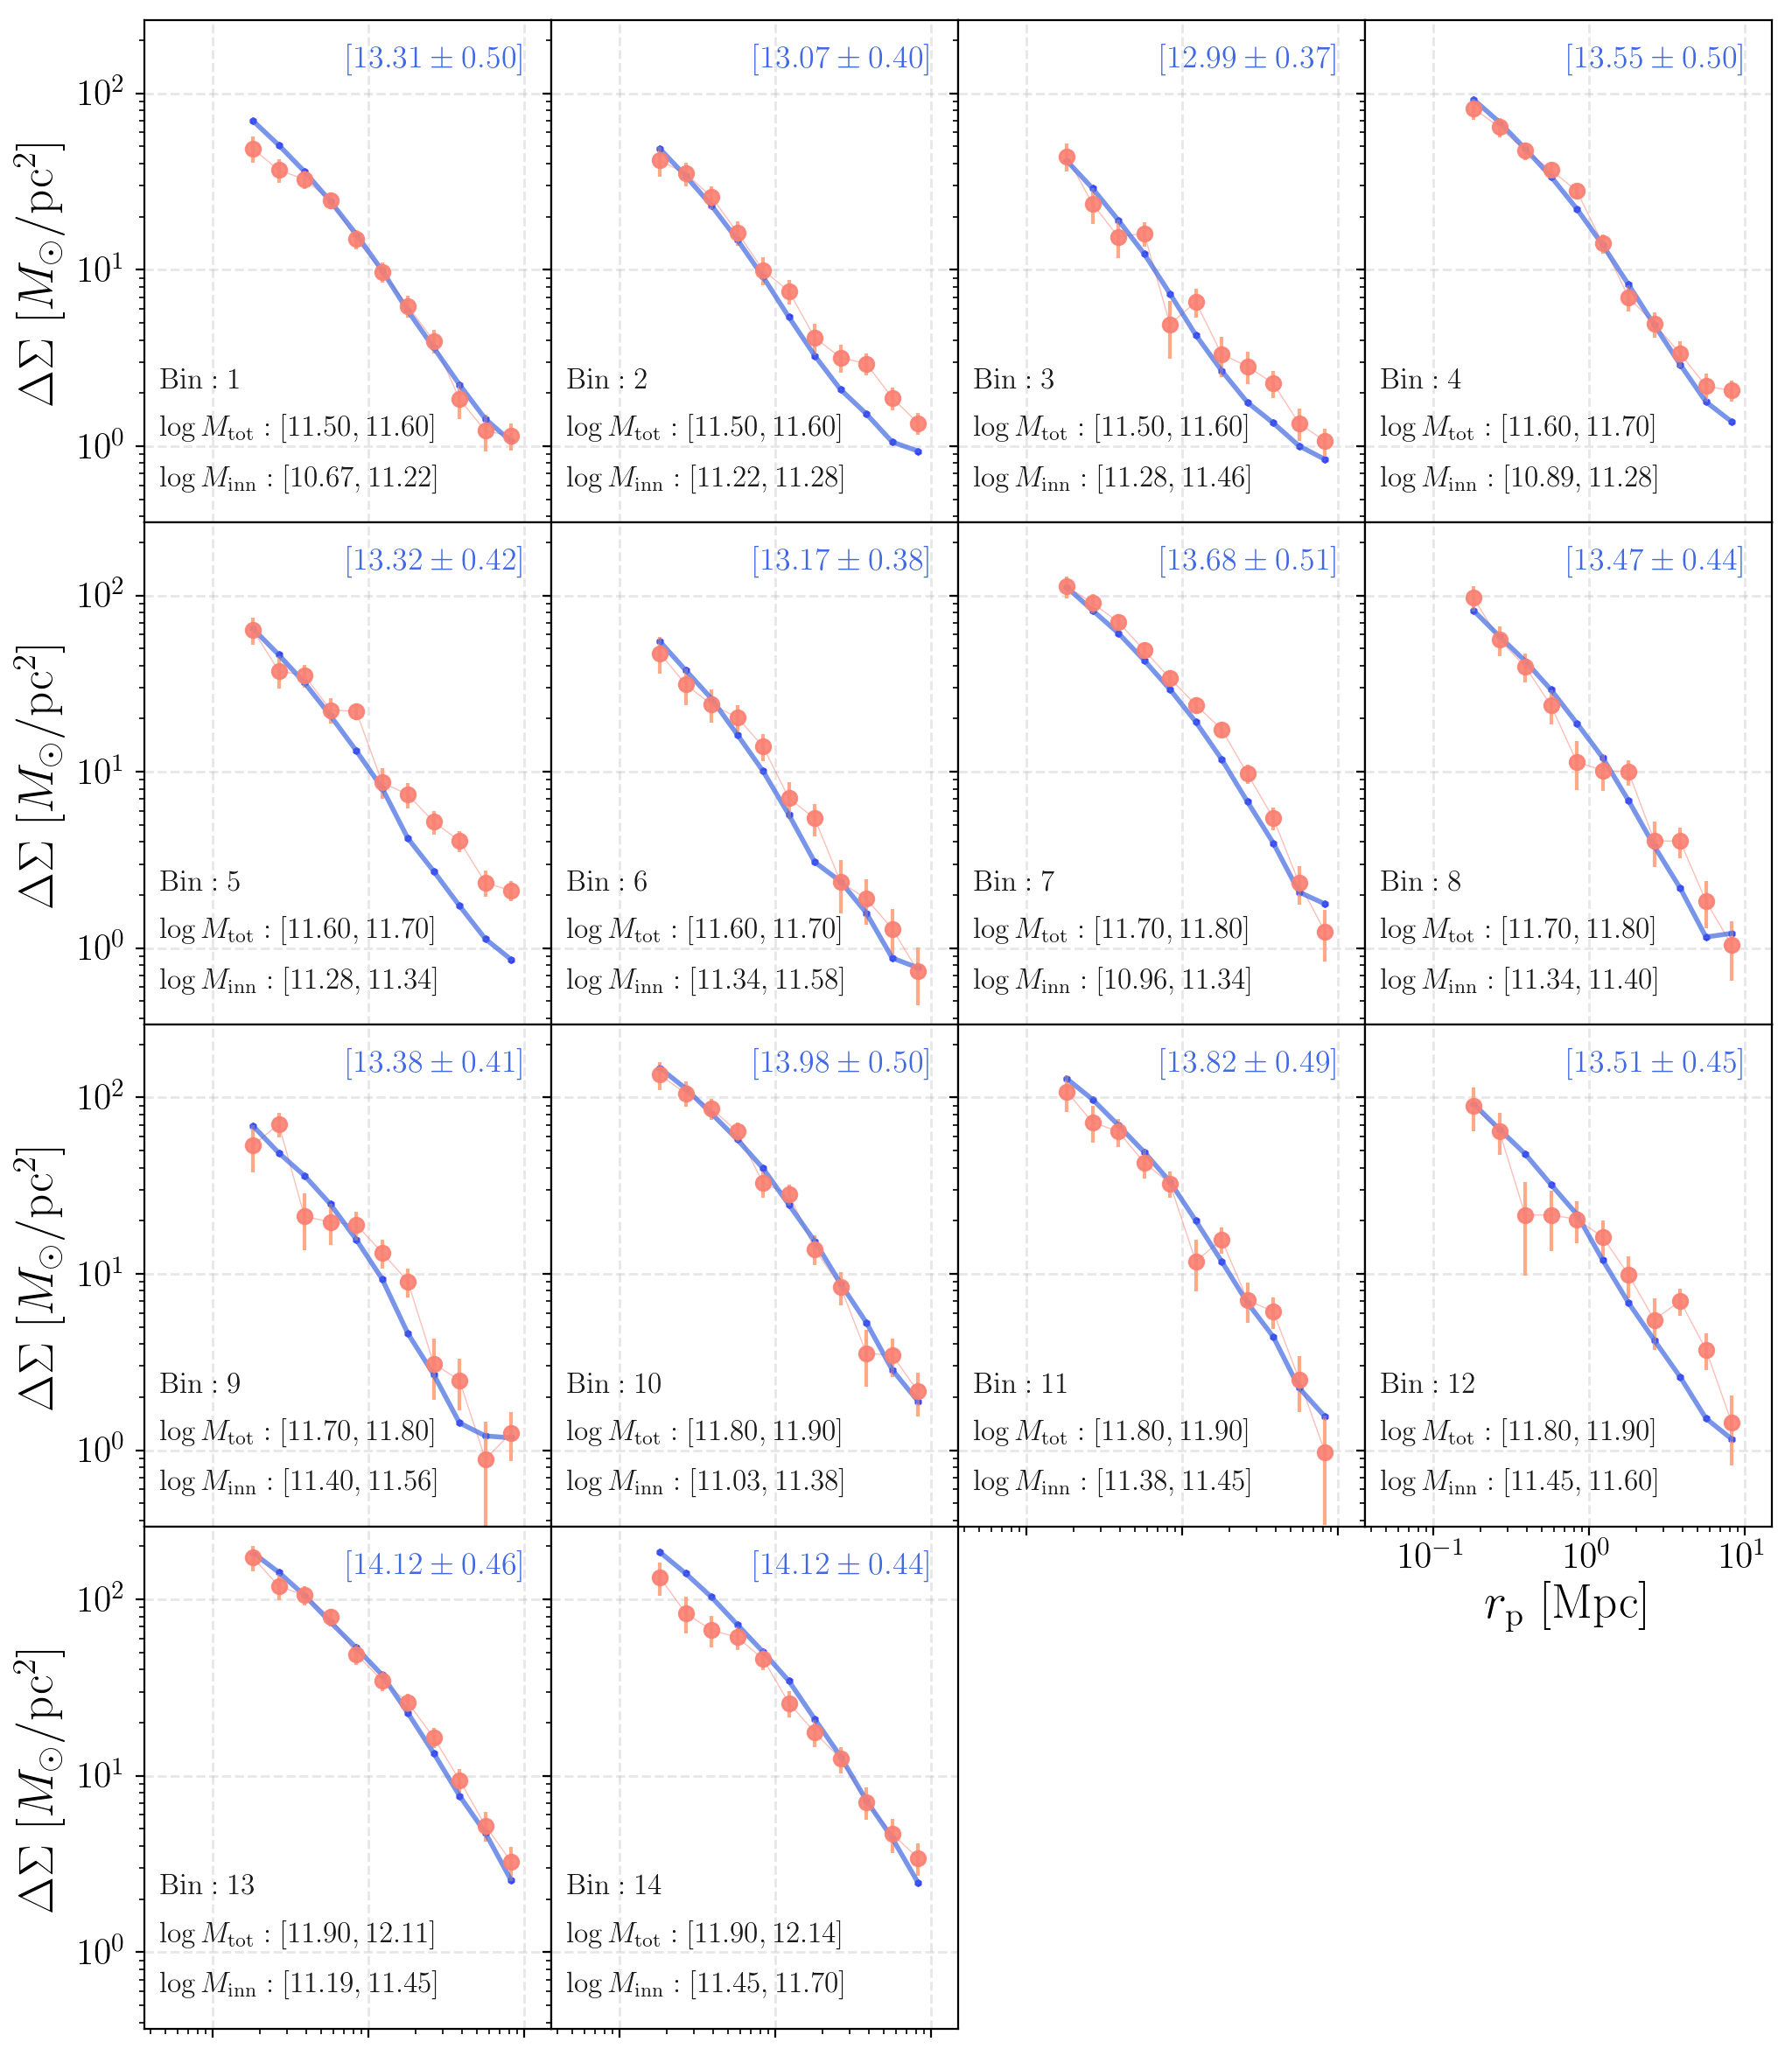

In [313]:
um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac2, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)

### Test new frac3 model 

In [5]:
config_file = '/Users/song/Downloads/asap_smdpl_mmax_m10_test3.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin5_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.5.fits
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 14 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.5000 -- 12.4000 in 9 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    9 bins at 11.50 < logMtot < 12.40
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [6]:
asap_test3 = np.load('/Users/song/Downloads/asap_smdpl_mmax_m10_test3_run.npz')
asap_test3_best = asap_test3['best']
print(asap_test3_best)

[ 0.55023475  4.15465256 -0.02109423  0.12736362  0.79654872  0.29729461
  0.98493446]


# lnLikelihood: 99.353772, -421.250299, -321.896527
# Chi2: 257.473651, 176.778252, 434.251903
# N_data - N_param: 166


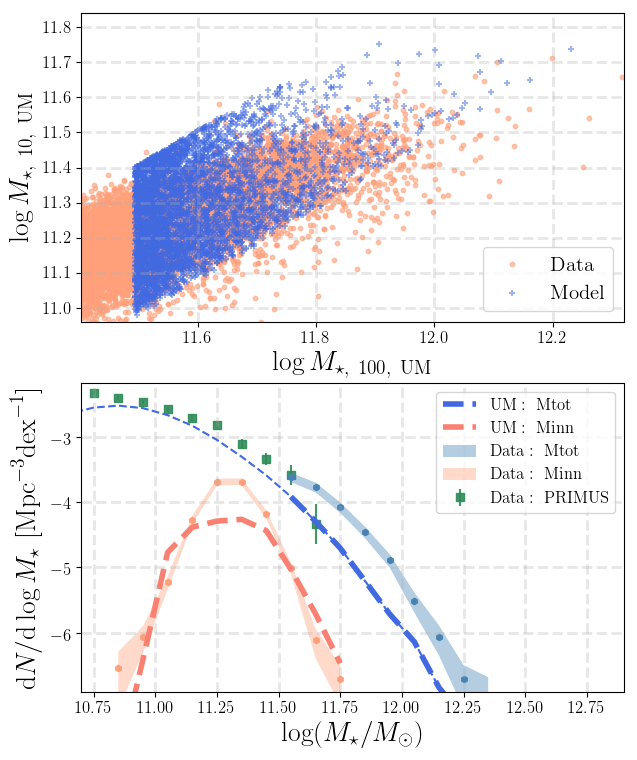

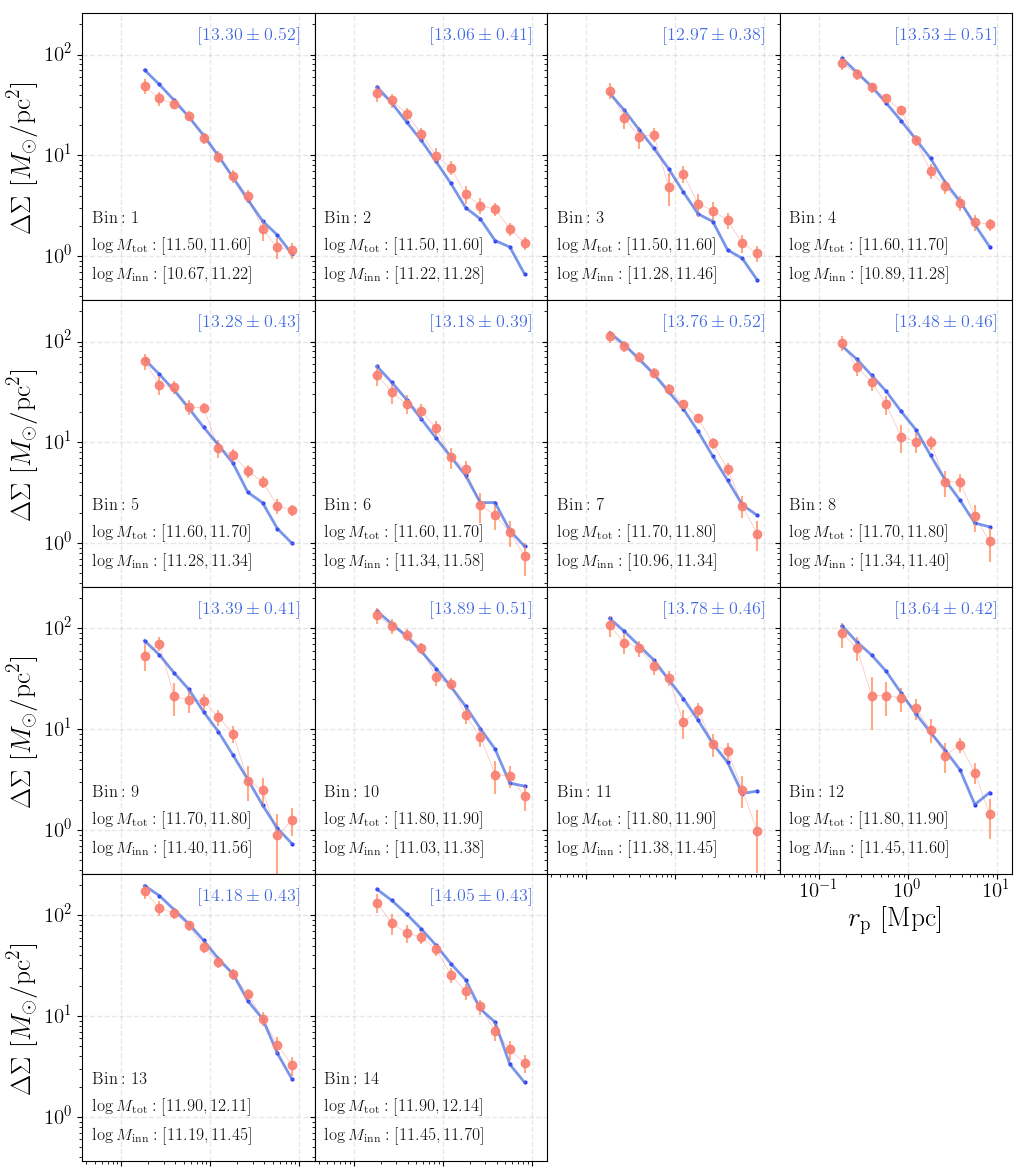

In [7]:
#param_frac3 = [0.620017, 3.428879, -0.025, 0.06, 0.75, 0.24, 0.9]
param_frac3 = asap_test3_best

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac3, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac3, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac3, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)

/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


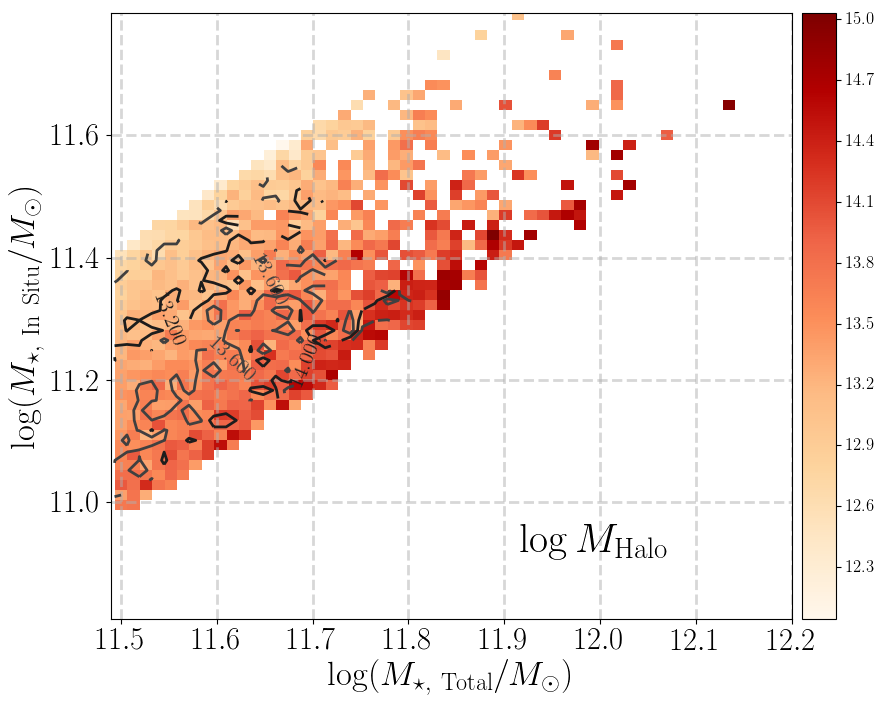

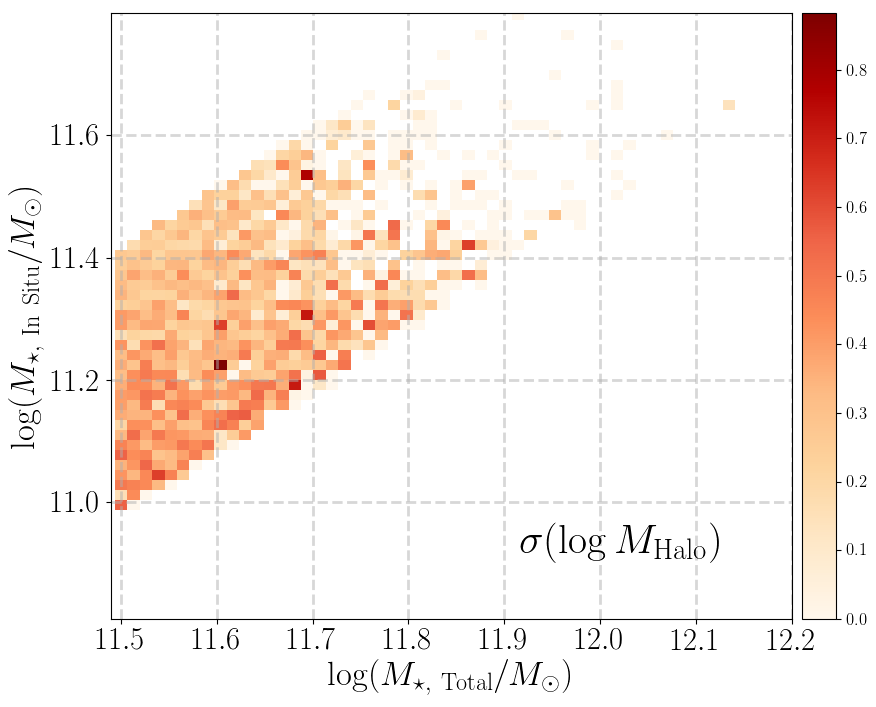

In [11]:
um_mod_predicted = asap_predict_model(
    param_frac3, cfg, obs_data, um_data, 
    show_smf=False, show_dsigma=False, return_all=True)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.nanmedian, 
                           x_lim=[11.49, 12.2], y_lim=[10.81, 11.799])


# Scatter
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.nanstd, contour=False,
                           x_lim=[11.49, 12.2], y_lim=[10.81, 11.799], 
                           title=r'$\sigma(\log M_{\mathrm{Halo}})$')

#### Test `frac4` model

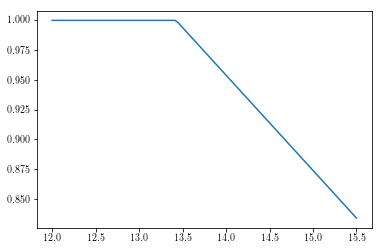

In [36]:
from asap.full_mass_profile_model import frac_from_logmh

logmh = np.linspace(12.0, 15.5, 100)

frac = frac_from_logmh(logmh, -0.08, 0.85)

plt.plot(logmh, frac)

In [21]:
config_file = '../asap/asap_test_config.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_new.npy
# Covariances for SMFs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


# lnLikelihood: -560.197045, -391.276560, -951.473604
# Chi2: 1617.372827, 247.078108, 1864.450935
# N_data - N_param: 143


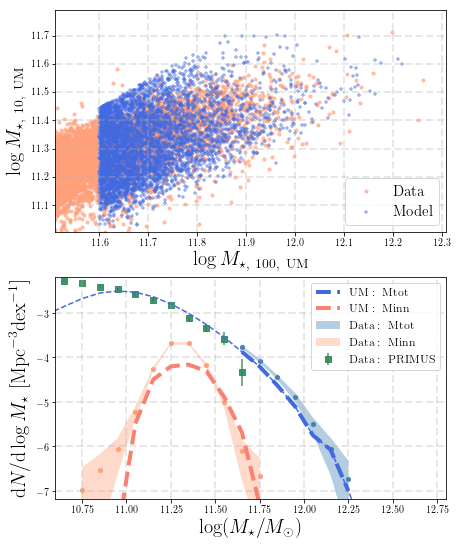

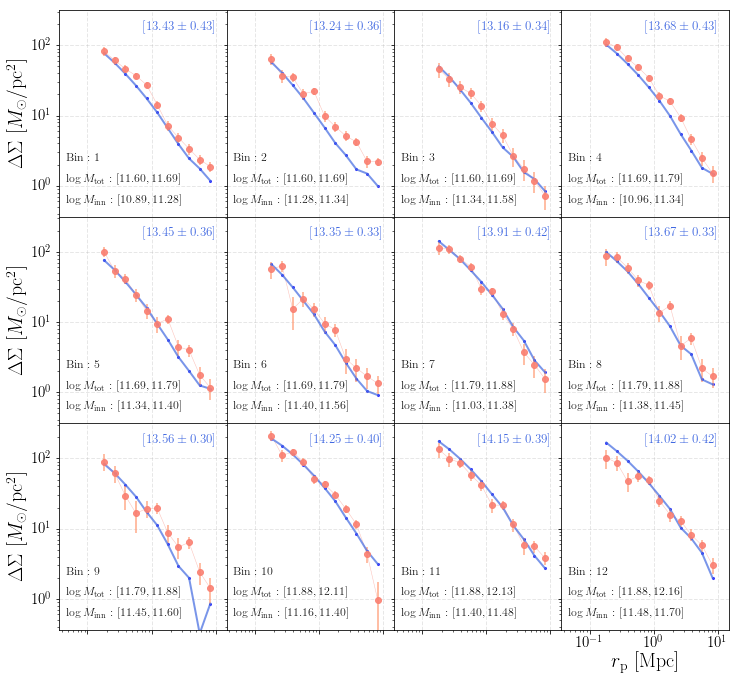

In [35]:
param_frac4 = [0.599, 3.669, -0.048, 0.02, 0.7, -0.07, 0.18]

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac4, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac4, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac4, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)

#### Test `frac5` model

In [42]:
config_file = '../asap/asap_test_config.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_new.npy
# Covariances for SMFs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


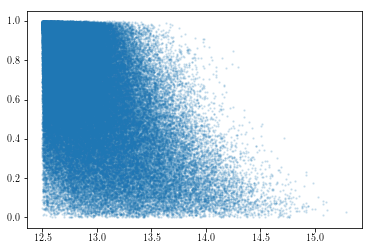

In [56]:
logmh = um_data['um_mock']['logmh_vir']
ms_ins = um_data['um_mock']['sm']
ms_exs = um_data['um_mock']['icl']
ms_tot = um_data['um_mock']['icl'] + um_data['um_mock']['sm']

mask = logmh >= 12.5

plt.scatter(logmh[mask], (ms_ins / ms_tot)[mask], s=2, alpha=0.15)

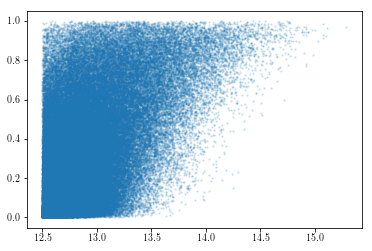

In [55]:
plt.scatter(logmh[mask], (ms_exs / ms_tot)[mask], s=2, alpha=0.15)

# lnLikelihood: -510.684422, -400.582114, -911.266536
# Chi2: 1509.367349, 251.102881, 1760.470230
# N_data - N_param: 142


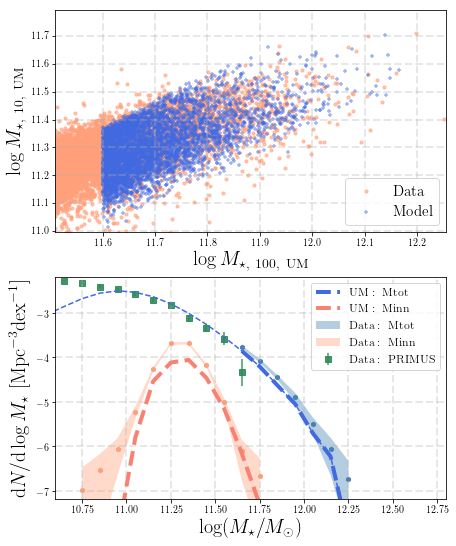

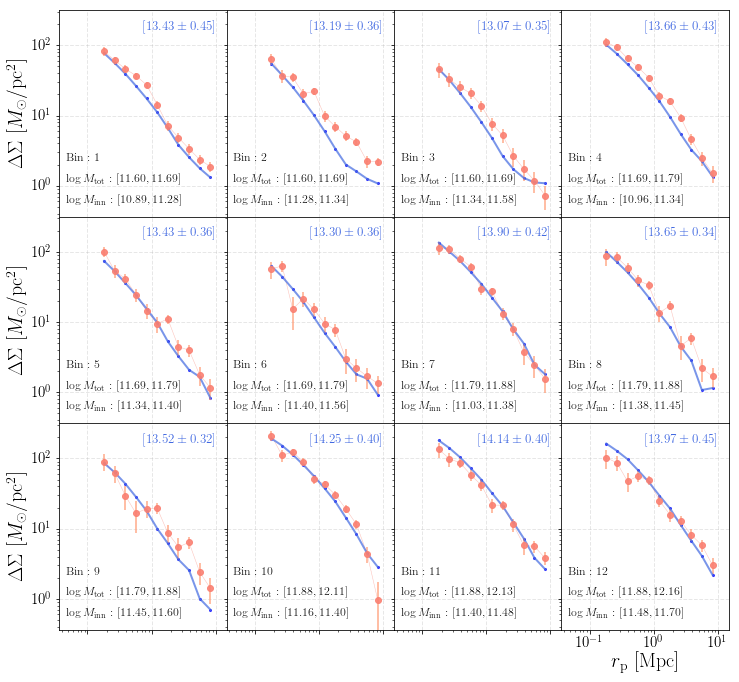

In [61]:
param_frac5 = [0.599, 3.669, -0.048, 0.02, 0.05, 0.7, -0.07, 0.20]

smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac5, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
smf_chi2, dsigma_chi2 = asap_ln_like(param_frac5, cfg, obs_data, um_data, 
                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, (smf_lnlike + dsigma_lnlike)))
print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

um_smf_tot, um_smf_inn, um_dsigma = asap_predict_model(
    param_frac5, cfg, obs_data, um_data, show_smf=True, show_dsigma=True)